# Builder Locations

Generate a map of the united states using only census data, then overlay all zip codes where one or more specified builders are located.

Also make sure to look at the related notebooks named `home_prices.ipynb` and `housing_growth.ipynb`

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
# Get all locations in the United States
zip_df = pd.read_csv('../inputs/zip_codes.csv', dtype={'Zip Code': str}) # State (abbreviated and full), City, Zip Code, Lat, Long
zip_df.head()

,State,State Abbreviated,City,Zip Code,Latitude,Longitude
0,Alabama,AL,Abbeville,36310,31.5755,-85.2790
1,Alabama,AL,Abernant,35440,33.3110,-87.1898
2,Alabama,AL,Adamsville,35005,33.5884,-86.9597
3,Alabama,AL,Addison,35540,34.2056,-87.1948
4,Alabama,AL,Adger,35006,33.4343,-87.1675


In [28]:
# Get home builder locations in the United States
home_sales_df = pd.read_csv('../inputs/home_sales_bhi.csv')
home_sales_df['Zip Code'] = home_sales_df['BHIZip'].astype('str').str.rstrip('.0')
home_sales_df = home_sales_df.drop(['BHIZip'], axis=1)
home_sales_df.head()

,IndustryPlanID,BHIBrandName,BHIState,BHICity,PlanName,Bedrooms,Baths,BaseSqFt,Garage,Stories,BasePrice,Zip Code
0,17,Classic Homes,CO,Colorado Springs,Dynasty,7,5,5154.0,3.0,2.0,883300.0,80921
1,53,Saddlehorn,SC,Pelzer,Williamsburg A,4,3,2915.0,2.0,2.0,524990.0,29669
2,54,Neidhart Enterprises Inc.,AZ,Phoenix,Geiger,4,4,4125.0,3.0,1.0,725000.0,85225
3,55,Neidhart Enterprises Inc.,AZ,Phoenix,Lamaide,3,2,2664.0,3.0,1.0,489000.0,85225
4,56,Neidhart Enterprises Inc.,AZ,Phoenix,Glaser,3,2,1919.0,1.0,1.0,479000.0,85225


In [29]:
# Get locations where we should be building
recommended_locations_df = pd.read_csv('../outputs/housing_growth.csv')
# Only recommend the top 10 locations (requires high population, and predicted continued growth)
min_population = 20000
max_recomendations = 10
recommended_locations_df = recommended_locations_df[(recommended_locations_df['Total Population'] >= min_population) & (recommended_locations_df['% Difference'] > 0)]
recommended_locations_df = recommended_locations_df.sort_values(['% Difference', 'Predicted Occupied Housing Units'], ascending=True).reset_index(drop=True)
recommended_locations_df = recommended_locations_df.head(max_recomendations)
recommended_locations_df = recommended_locations_df[['Latitude', 'Longitude']]
recommended_locations_df.head()

,Latitude,Longitude
0,42.9357,-112.4679
1,43.0871,-75.2315
2,33.6299,-112.1316
3,32.4593,-82.9381
4,39.0417,-94.7202


In [30]:
# Merge tables together then remove all columns not needed for mapping
df = pd.merge(zip_df, home_sales_df, on='Zip Code', how='outer')
del zip_df # Free memory
del home_sales_df # Free memory
df = df.drop(['BasePrice', 'BaseSqFt', 'Baths', 'Bedrooms', 'BHICity', 'BHIState', 'City', 'Garage', 'IndustryPlanID', 'PlanName', 'State', 'State Abbreviated', 'Stories'], axis=1)
df.head()

,Zip Code,Latitude,Longitude,BHIBrandName
0,36310,31.5755,-85.2790,NaN
1,35440,33.3110,-87.1898,NaN
2,35005,33.5884,-86.9597,NaN
3,35540,34.2056,-87.1948,NaN
4,35006,33.4343,-87.1675,NaN


In [31]:
# Define the boundaries of the continental United States
us_bounds = { 'lat_min': 24.5, 'lat_max': 49.5, 'lon_min': -124.75, 'lon_max': -66.95 }
# Remove Hawaii and Alaska
us_df = df[(df['Latitude'] >= us_bounds['lat_min']) &
           (df['Latitude'] <= us_bounds['lat_max']) &
           (df['Longitude'] >= us_bounds['lon_min']) &
           (df['Longitude'] <= us_bounds['lon_max'])]
centex_df = df[(df['BHIBrandName'] == 'Centex Homes')]
delwebb_df = df[(df['BHIBrandName'] == 'Del Webb')]
pulte_df = df[(df['BHIBrandName'] == 'Pulte Homes')]
# Filter the data DataFrame to exclude rows with zip codes in the builder DataFrames
us_df = us_df[~us_df['Zip Code'].isin(centex_df['Zip Code'])]
us_df = us_df[~us_df['Zip Code'].isin(delwebb_df['Zip Code'])]
us_df = us_df[~us_df['Zip Code'].isin(pulte_df['Zip Code'])]
del df # Free memory

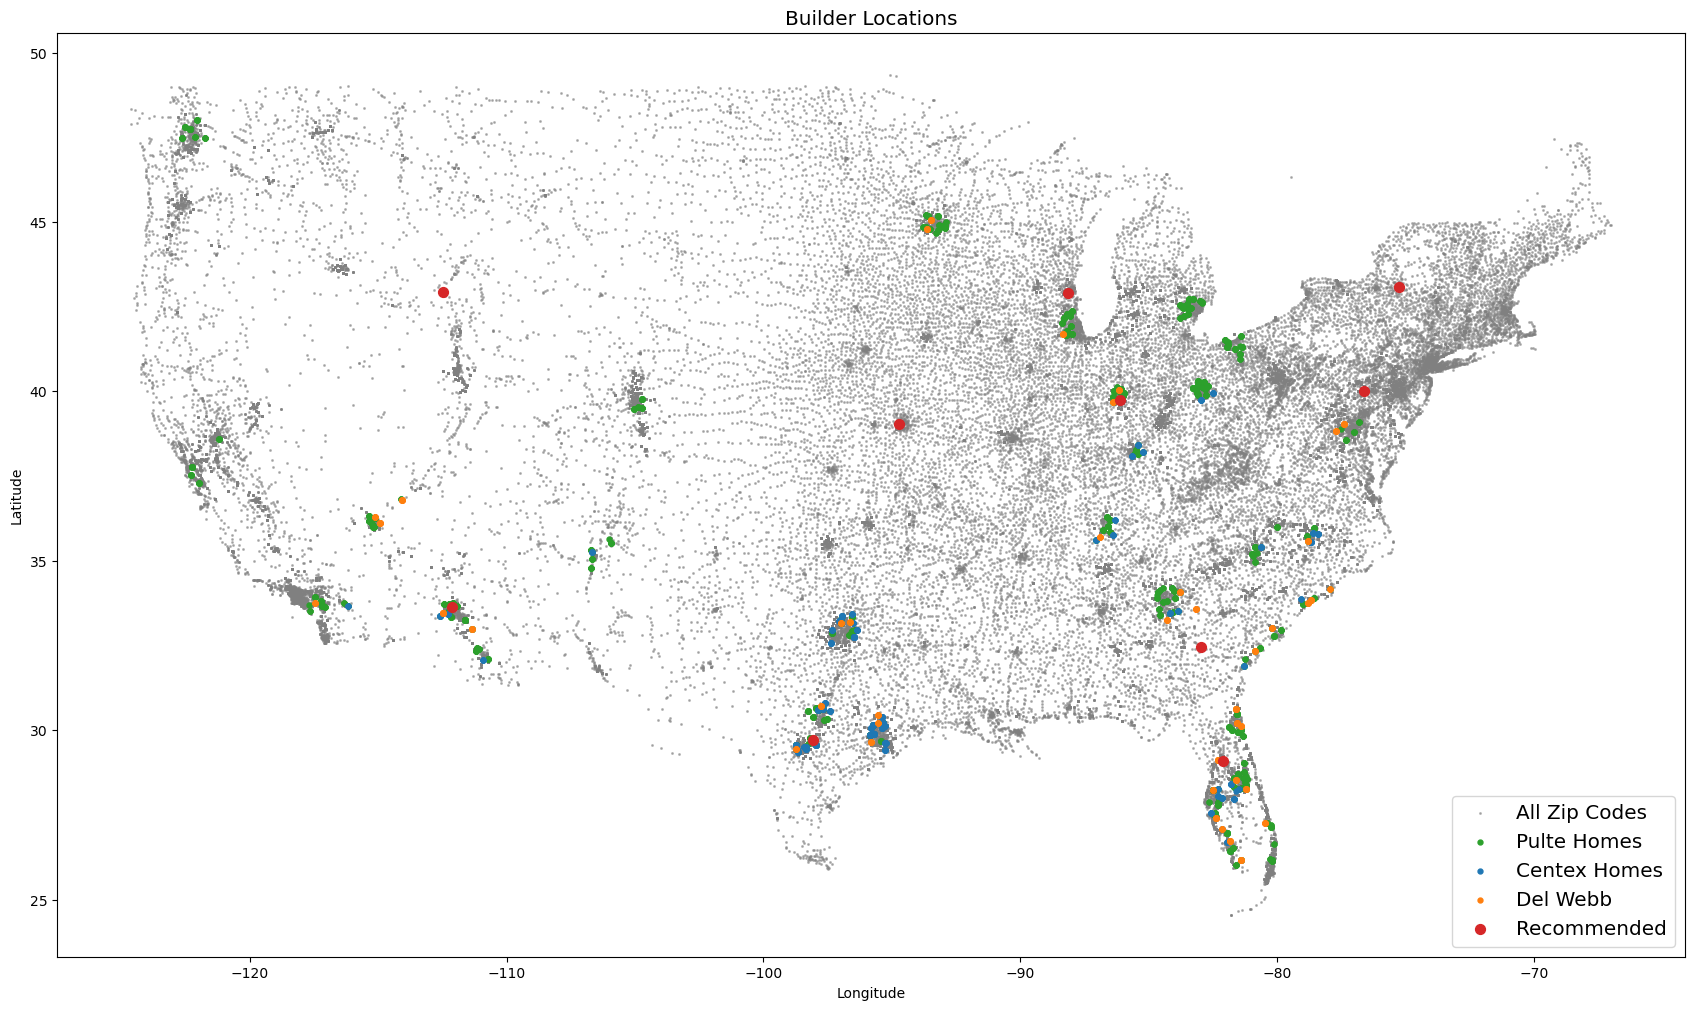

In [32]:
builder_dot_size = 50

plt.figure(figsize=(21,12))
plt.scatter(us_df['Longitude'],us_df['Latitude'], c='grey', marker='.', s=(builder_dot_size/10), alpha=0.5, label='All Zip Codes')
plt.scatter(pulte_df['Longitude'],pulte_df['Latitude'], c='C2', marker='.', s=builder_dot_size, label='Pulte Homes')
plt.scatter(centex_df['Longitude'],centex_df['Latitude'], c='C0', marker='.', s=builder_dot_size, label='Centex Homes')
plt.scatter(delwebb_df['Longitude'],delwebb_df['Latitude'], c='C1', marker='.', s=builder_dot_size, label='Del Webb')
plt.scatter(recommended_locations_df['Longitude'],recommended_locations_df['Latitude'], c='C3', marker='.', s=builder_dot_size*4, label='Recommended')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='lower right', fontsize='x-large')
plt.title("Builder Locations", fontsize='x-large')
plt.show()